In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from pylite.test import *
from pylite.utils import *
from pylite.learner import *
from pylite.Callbacks import *

In [3]:
x_train,y_train,x_valid,y_valid = get_mnist_data()
loss_func = F.cross_entropy
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()
bs = 512
train_ds, valid_ds = get_ds(x_train,y_train,x_valid,y_valid)
data = TabularDataBunch(*get_dls(train_ds, valid_ds, bs))

In [4]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

def get_model_func(lr=0.5): return partial(get_model, lr=lr)

def create_learner(model_func, loss_func, data, cbs=None, cb_funcs=None):
    return Learner(*model_func(data), loss_func, data, cbs, cb_funcs)

In [5]:
stats = AvgStatsCallback([accuracy])
learn = Learner(*get_model(data), loss_func, data, cbs=stats)

In [6]:
learn.fit(1)

train: [0.69141015625, tensor(0.7947)]
valid: [0.3105899658203125, tensor(0.9109)]


In [7]:
# #export
# def annealer(f):
#     def _inner(start, end): return partial(f, start, end)
#     return _inner

# @annealer
# def sched_lin(start, end, pos): return start + pos*(end-start)

In [8]:
f = sched_lin(1,2)
f(0.3)

1.3

In [9]:

#export
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

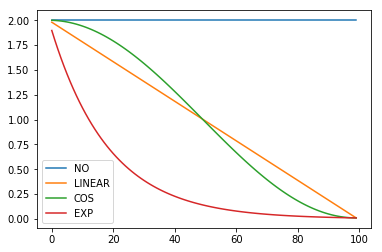

In [10]:
annealings = "NO LINEAR COS EXP".split()

a = torch.arange(0, 100)
p = torch.linspace(0.01,1,100)

fns = [sched_no, sched_lin, sched_cos, sched_exp]
for fn, t in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(o) for o in p], label=t)
plt.legend();

# Combine scheds

In [11]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)])

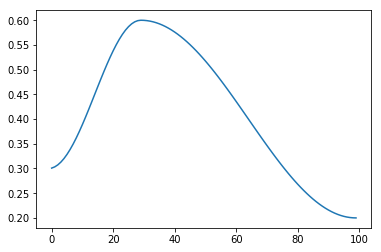

In [12]:

plt.plot(a, [sched(o) for o in p])

In [13]:
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [14]:
learn = create_learner(get_model_func(0.3), loss_func, data, cb_funcs=cbfs)

In [15]:
learn.fit(3)

train: [0.75369796875, tensor(0.7912)]
valid: [0.3148401123046875, tensor(0.9110)]
train: [0.2935860546875, tensor(0.9149)]
valid: [0.2329811279296875, tensor(0.9347)]
train: [0.23729068359375, tensor(0.9315)]
valid: [0.209786767578125, tensor(0.9408)]


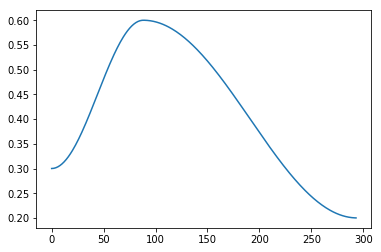

In [16]:
learn.recorder.plot_lr()

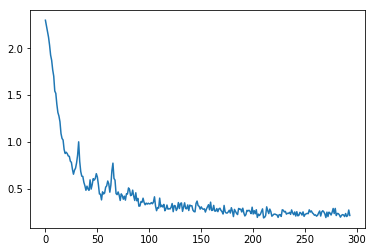

In [17]:
learn.recorder.plot_loss()

In [18]:
learn.cbs[0].in_train

False

In [19]:
Exception

Exception